In [296]:
from scipy.stats import beta
from pymc import rbeta

In [194]:
class Sample(object):
    def __init__(self, q, n=1000000):
        self.q = q
        self.n = n
        self.G = int(np.ceil(q*n))
        self.B = n - self.G
        
    def generate(self, from_file = None, seed=2016):
        self.seed = seed
        
        if from_file:
            name = "./samples/{}_{}.txt".format(str(self.q).replace(".",""),str(self.seed))
            self.line = np.loadtxt(name, dtype=np.int8)
            
        seed = np.random.seed(seed)
        line = np.append(np.ones(self.G, dtype = np.int8), np.zeros(self.B, dtype = np.int8))
        self.line = np.random.permutation(line)
        return self.line
    
    def save(self):
        name = "./samples/{}_{}.txt".format(str(self.q).replace(".",""),str(self.seed))
        np.savetxt(name, self.line,fmt="%d")

In [565]:
class Strategy(object):
    '''Gets a sample object and builds a test plan'''
    def __init__(self, sample, startig_test=1):
        self.q = beta(1,1)
        self.sample = sample
        self.queue = sample.line
        self.Ntests = 0
        self.Htests = 0
        self.test_now = startig_test
        self.G = 0
        self.B = 0
        self.q_history = []
        self.H_history = []
        self.name = ""
        
    def test(self):
        '''test needs to be implemented according to the relevant strategy'''
        pass
        raise NotImplementedError()
    def g_test(self, items):
        if items.size == 1:
            return
        self.Ntests += 1
        m = int(items.size/2)
        test, leave = np.split(items, [m])
        if all(test):
            self.G += test.size
            self.g_test(leave)
        else:
            # Leave is now binomial and back to queue
            self.queue = np.append(leave, self.queue)
            self.g_test(test)
    
    def update(self, h_now):
        '''updates all histories'''
        self.Ntests += 1
        self.Htests += 1
        self.H_history.append(h_now)
        self.q_history.append(self.G / ( 1+ self.G + self.B))
        
    def plot(self, fig = None):
        l = len(self.H_history)
        if fig is None:
            fig, ax = plt.subplots(2,figsize=(16,12))
        ax = fig.get_axes()
        
        # Axis 0 - q History
        ax[0].set_title("q History")
        ax[0].plot(self.q_history, label=self.name)
        ax[0].set_xlim(0,l)
        ax[0].legend(loc='best')
        
        # Axis 1 - H history
        ax[1].set_title("H History")
        ax[1].plot(self.H_history[::1], label = self.name)
#         ax[1].plot([0,l],[np.mean(self.H_history)]*2, ls='--', lw=2, c='b',
#                    label="{} Mean = {:.4f}".format(self.name, np.mean(self.H_history)))
        ax[1].set_xlim(0,l)
        ax[1].legend()
        
        
        return fig, ax
    
class DOD(Strategy):
    
    def test(self):
        self.name = "Double or Divide"
        h_now = self.test_now
        while self.queue.size > 0:
            # Update histories
            self.update(h_now)
            items, self.queue = np.split(self.queue,[h_now])
            if all(items):
                self.G += items.size
                h_now *= 2
            else:
                self.B +=1
                self.g_test(items)
                h_now = max(1, h_now//2)
            
class OneByOne(Strategy):
    def test(self):
        self.name = "One by One"
        while self.queue.size > 0:
            self.update(1)
            items, self.queue = np.split(self.queue,[1])
            if all(items):
                self.G += items.size
            else:
                self.B +=1

class Pairwise(Strategy):
    h_now = 2
    def test(self):
        self.name = "Pairwise"
        while self.queue.size > 0:
            self.update(2)
            items, self.queue = np.split(self.queue,[2])
            if all(items):
                self.G += items.size
            else:
                self.B += 1
                self.g_test(items)
                
class NonAdaptiveDecision(Strategy):
    def test(self):
        self.name = "Non Adaptive"
        h_now = self.test_now
        after = 1000
        while self.queue.size > 0:
            # Update histories
            self.update(h_now)
            last_q = self.q_history[-1]
            if (self.G + self.B > after) and (last_q < 0.835):
                break
            items, self.queue = np.split(self.queue,[h_now])
            if all(items):
                self.G += items.size
                h_now *= 2
            else:
                self.B +=1
                self.g_test(items)
                h_now = max(1, h_now//2)
        if last_q < 0.618:
            # Do one by one
            self.name += " -> 1by1"
            while self.queue.size > 0:
                self.update(1)
                items, self.queue = np.split(self.queue,[1])
                if all(items):
                    self.G += items.size
                else:
                    self.B +=1
        elif last_q < 0.835:
            # Do Pairwise
            self.name += " -> pairwise"
            while self.queue.size > 0:
                self.update(2)
                items, self.queue = np.split(self.queue,[2])
                if all(items):
                    self.G += items.size
                else:
                    self.B += 1
                    self.g_test(items)
        else:
            self.name += " -> DOD"

# Double or Divide

Real:  8200 1800 

Double or Divide
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 8200   |  1800    |  7484    |  3521   | 4.4181 

Non Adaptive -> pairwise
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 8200   |  1800    |  7317    |  5314   | 2.1479 

One by One
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 8200   |  1800    | 10000    | 10000   | 1.0000 

Pairwise
Goods   | Bads     | Tests    | H-Tests | Mean H-Test
 8200   |  1800    |  7303    |  5503   | 2.0000 



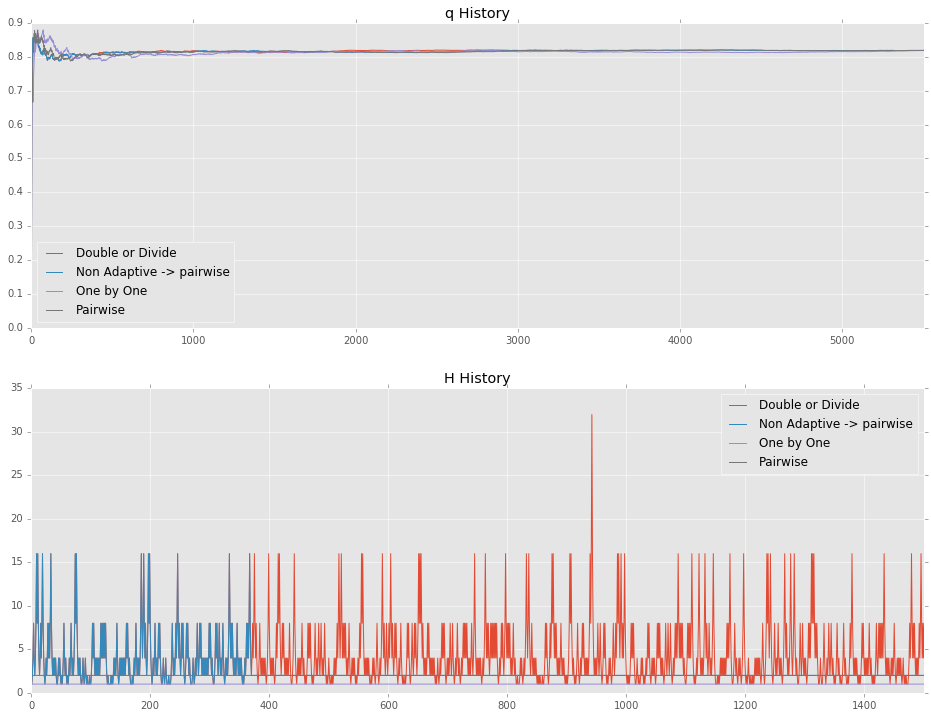

In [567]:
s = Sample(0.82, n=10000)
s.generate(seed=np.random.randint(100,400))
d = DOD(s,)
e = OneByOne(s)
f = Pairwise(s)
strats = [ DOD, NonAdaptiveDecision,OneByOne, Pairwise]
# strats = [NonAdaptiveDecision]
# fig, axs = plt.subplots(2)
fig = None
print("Real: ",s.G, s.B,'\n')
for strat in strats:
    policy = strat(s)
    policy.test()
    print (policy.name)
    print ("======================================================")
    if policy.queue.size != 0:
        print ("WARNING: Does not finish")
    print ("Goods   | Bads     | Tests    | H-Tests | Mean H-Test")
    print ("{:5d}   | {:5d}    | {:5d}    | {:5d}   | {:.4f} ".format(policy.G, policy.B,
                                                       policy.Ntests, policy.Htests,
                                                       np.mean(policy.H_history)))
    print()
    fig, ax = policy.plot(fig)
ax[1].set_xlim(0,1500)
plt.show()

# One by One

0
500 500
500 500
Tests:  1000 --- H-Tests:  1000
1.0


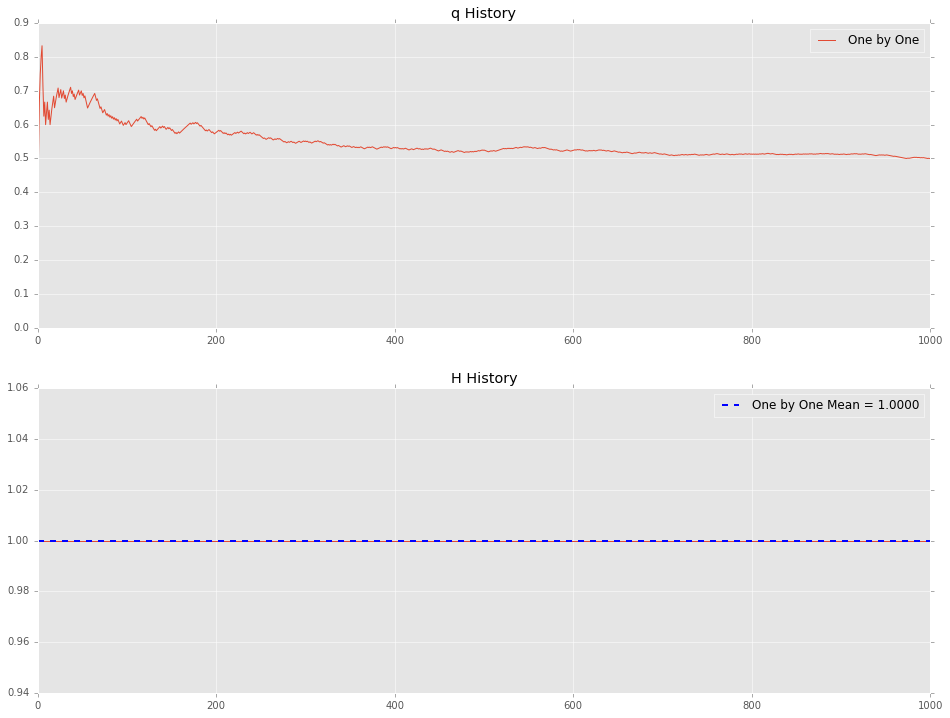

In [464]:
s = Sample(0.5, n=1000)
s.generate()
d = OneByOne(s)

d.test()

print(d.queue.size)
print(s.G, s.B)
print(d.G, d.B)
print("Tests: ", d.Ntests, "--- H-Tests: ", d.Htests)
print (np.mean(d.H_history))
d.plot()
plt.show()

# Pairwise

0
707 293
707 293
Tests:  886 --- H-Tests:  594
2.0


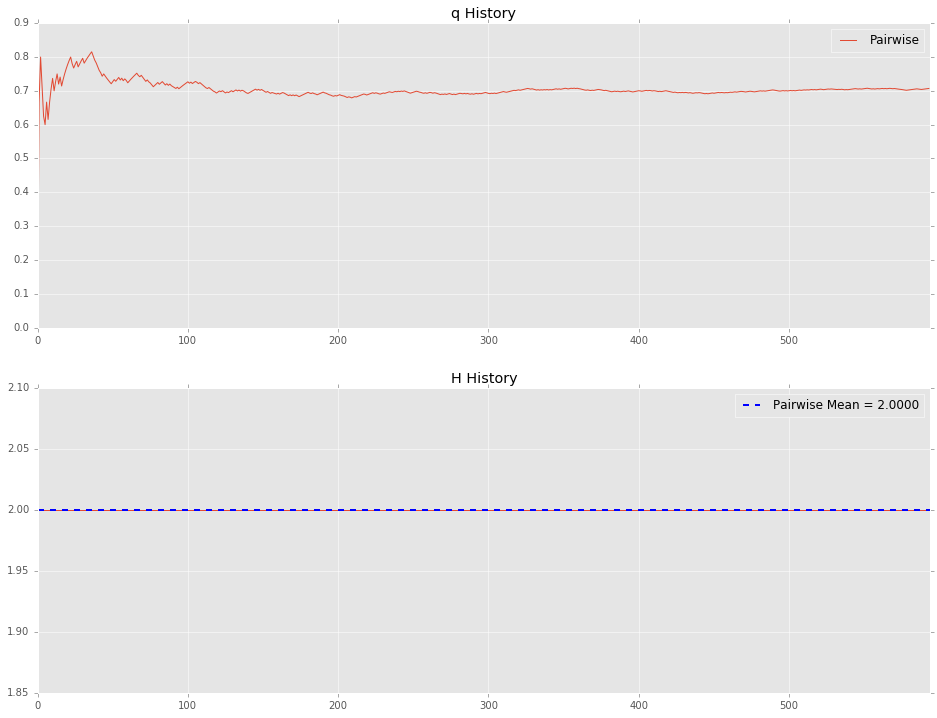

In [463]:
s = Sample(0.707, n=1000)
s.generate()
d = Pairwise(s)

d.test()

print(d.queue.size)
print(s.G, s.B)
print(d.G, d.B)
print("Tests: ", d.Ntests, "--- H-Tests: ", d.Htests)
print (np.mean(d.H_history))
d.plot()
plt.show()

In [ ]:
qs = np.arange(0.01,1,0.01)
mean_H = []
for q in qs:
    s = Sample(q, n=10000)
    s.generate()
    d = DOD(s)
    d.test()
    mean_H.append(np.mean(d.H_history))
    print (q, end=" ")

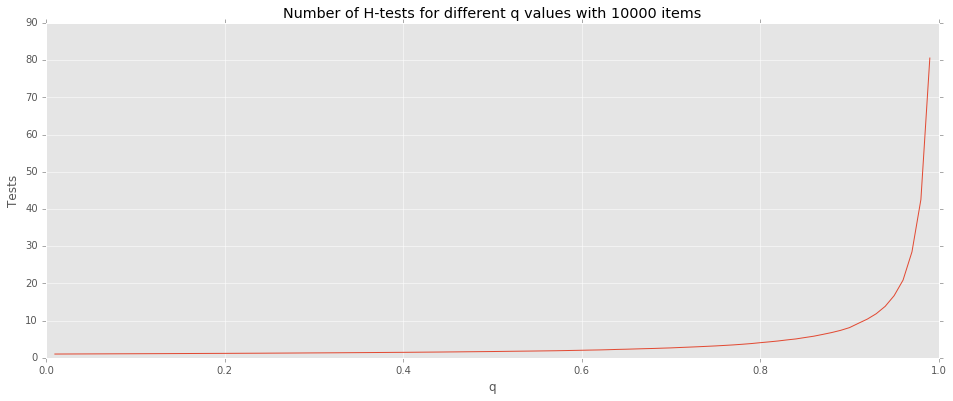

In [412]:
fig, ax = plt.subplots()
ax.plot(qs,mean_H)
ax.set_title('Number of H-tests for different q values with 10000 items')
ax.set_xlabel('q')
ax.set_ylabel('Tests')
plt.show()